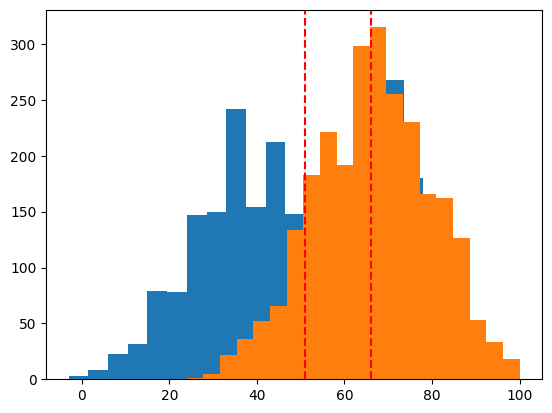

Temperature Median of Training Set: 51.0
Humidity Median of Training Set: 66.0


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("daily_data.csv")

# Ignore the last 100 rows
df = df[:-100]

# Calculate medians
temp_median = df["DailyAverageDryBulbTemperature"].median()
humidity_median = df["DailyAverageRelativeHumidity"].median()

# Plot temperature histogram
plt.hist(df["DailyAverageDryBulbTemperature"], bins=20)
plt.axvline(temp_median, color='red', linestyle='dashed')

# Plot humidity histogram
plt.hist(df["DailyAverageRelativeHumidity"], bins=20)
plt.axvline(humidity_median, color='red', linestyle='dashed')

# Show the plots
plt.show()

# Print the median values
print("Temperature Median of Training Set:", temp_median)
print("Humidity Median of Training Set:", humidity_median)

In [2]:
df = pd.read_csv("daily_data.csv",usecols=[11, 12,24,25])
df = df[:-100]

# Consider the T(small amount of rain or snow) value for precipitation and Snow as 0.00/no precipitation and snow
df["DailyPrecipitation"] = df["DailyPrecipitation"].replace("T", 0.00).astype(float)
df["DailySnowDepth"] = df["DailySnowDepth"].replace("T", 0.00).astype(float)
df

,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyPrecipitation,DailySnowDepth
0,25.0,46.0,0.00,0.0
1,32.0,57.0,0.00,0.0
2,27.0,74.0,0.57,0.0
3,39.0,86.0,0.22,1.0
4,27.0,59.0,0.00,0.0
...,...,...,...,...
2563,27.0,61.0,0.00,0.0
2564,48.0,72.0,0.12,0.0
2565,38.0,66.0,0.11,0.0
2566,22.0,61.0,0.03,0.0


In [3]:
# Transition Matrix/////////////////////////////////////////////////////////////
Precipitation = df["DailyPrecipitation"]
Snow = df["DailySnowDepth"]
sum = 0
p_rs_rs = np.sum([1 if (Precipitation[i] > 0.00 or Snow[i] > 0.00) and
                    (Precipitation[i+1] > 0.00 or Snow[i+1] > 0.00) else 0
                                              for i in range(0,len(df)-1)])
p_rs_nrs = np.sum([1 if (Precipitation[i] > 0.00 or Snow[i] > 0.00) and
                  (Precipitation[i+1] == 0.00 and Snow[i+1] == 0.00) else 0
                                              for i in range(0,len(df)-1)])
sum = p_rs_rs + p_rs_nrs
p_rs_rs /= sum
p_rs_nrs /= sum

p_nrs_rs = np.sum([1 if (Precipitation[i+1] > 0.00 or Snow[i+1] > 0.00) and
                    (Precipitation[i] == 0.00 and Snow[i] == 0.00) else 0
                                              for i in range(0,len(df)-1)])
p_nrs_nrs = np.sum([1 if (Precipitation[i] == 0.00 and Snow[i] == 0.00) and
                    (Precipitation[i+1] == 0.00 and Snow[i+1] == 0.00) else 0
                                              for i in range(0,len(df)-1)])
sum = p_nrs_rs + p_nrs_nrs
p_nrs_rs /= sum
p_nrs_nrs /= sum

transition_matrix = np.array([[p_rs_rs, p_rs_nrs], [p_nrs_rs, p_nrs_nrs]])
transition_matrix

array([[0.60626588, 0.39373412],
       [0.33549784, 0.66450216]])

In [4]:
#Emission Matrix////////////////////////////////////////////////////////////////
#51.0. Any data point with a temperature higher or equal
#to this threshold will be classified as high, others are low
#66.0. Any data point with a humidity higher or equal to this
#threshold will be classified as high, others are low
Temperature = df["DailyAverageDryBulbTemperature"]
Humidity = df["DailyAverageRelativeHumidity"]

p_obs_given_rs = np.zeros((1,4))
p_obs_given_nrs = np.zeros((1,4))
for i in range(0, len(df)):
    if Precipitation[i] > 0.00 or Snow[i] > 0.00:
        if Temperature[i] >= 51.0 and Humidity[i] >= 66.0:
            p_obs_given_rs[0][0] += 1
        elif Temperature[i] >= 51.0 and Humidity[i] < 66.0:
            p_obs_given_rs[0][1] += 1
        elif Temperature[i] < 51.0 and Humidity[i] >= 66.0:
            p_obs_given_rs[0][2] += 1
        else:
            p_obs_given_rs[0][3] += 1
    else:
        if Temperature[i] >= 51.0 and Humidity[i] >= 66.0:
            p_obs_given_nrs[0][0] += 1
        elif Temperature[i] >= 51.0 and Humidity[i] < 66.0:
            p_obs_given_nrs[0][1] += 1
        elif Temperature[i] < 51.0 and Humidity[i] >= 66.0:
            p_obs_given_nrs[0][2] += 1
        else:
            p_obs_given_nrs[0][3] += 1

p_obs_given_rs /= np.sum(p_obs_given_rs)
p_obs_given_nrs /= np.sum(p_obs_given_nrs)
emission_matrix = np.array([p_obs_given_rs[0], p_obs_given_nrs[0]])
emission_matrix

array([[0.35901778, 0.05757832, 0.3700254 , 0.21337849],
       [0.2480173 , 0.32876712, 0.11031002, 0.31290555]])

In [5]:
#initial_state//////////////////////////////////////////////////////////////////
p_rs = np.sum([1 if Precipitation[i] > 0.00 or Snow[i] > 0.00 else 0
                                  for i in range(0,len(df))])/len(df)
p_nrs = 1 - p_rs
initial_state = np.array([p_rs, p_nrs])
initial_state

array([0.45989097, 0.54010903])

In [12]:
def fowardAlgorithm(transition_matrix, emission_matrix, initial_distribution, observation):
    obs_map = {
        ("High", "High"): 0,
        ("High", "Low"): 1,
        ("Low",  "High"): 2,
        ("Low",  "Low"):  3
    }
    obs_index = obs_map.get(observation)
    if obs_index is None:
        raise ValueError(f"Invalid observation {observation}. Expected one of {list(obs_map.keys())}.")

    alpha_today = initial_distribution * emission_matrix[:, obs_index]
    sum_alpha = alpha_today.sum()
    if sum_alpha == 0:
        alpha_today = np.array([0.5, 0.5])
    else:
        alpha_today /= sum_alpha

    tomorrow_dist = np.dot(alpha_today, transition_matrix)
    prob_rain_snow = tomorrow_dist[0]

    if prob_rain_snow >= 0.5:
        statement = "Most likely will rain/snow tomorrow."
    else:
        statement = "Most likely no rain/snow tomorrow."

    return prob_rain_snow, statement

In [13]:
p, prediction = fowardAlgorithm(transition_matrix,emission_matrix,initial_state,("High","Low"))
print("probability:",p)
print("prediction:",prediction)

probability: 0.37063567286369803
prediction: Most likely no rain/snow tomorrow.
